In [11]:
import os
import sys
import pandas as pd
sys.path.append("../src")

In [12]:
from utils import ExperimentSetup

In [13]:
def load_metrics(region, experiment, depth):
    
    path = f"../results/{region}/{depth}/{experiment}/Model/Metrics/{region}_{depth}_{experiment}_depth_metrics.csv"
    if not os.path.exists(path):
        print(f"Warning: file missing: {path}")
        return None
    df = pd.read_csv(path, index_col=0, header=None).iloc[1:, :]
    return df

In [23]:
def collect_all_metrics(regions, experiments, depths):
    r2_all, mae_all, bias_all = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for region in regions:
        for depth in depths:
            for exp in experiments:
                df = load_metrics(region, exp, depth)
                for metric, container in zip(["R2", "MAE", "Bias"], [r2_all, mae_all, bias_all]):
                    s = df.loc[metric]
                    s.name = f"{region}_{exp}"
                    container = pd.concat([container, s], axis=1)
    return r2_all, mae_all, bias_all

In [24]:
r2_50, mae_50, bias_50 = collect_all_metrics(
    regions=ExperimentSetup.ALL_REGIONS,
    experiments=["S3OLCIBGC", "GCGOBGC"],
    depths=["50"]
)

In [26]:
r2_50

""


In [25]:
ExperimentSetup.ALL_REGIONS

['NA', 'STG']

In [17]:
def plot_bbp_comparison(
    r2_50, mae_50, bias_50, depth, save_path,
    mld_na=-36, mld_stg=-50, dpi=300
):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import ScalarFormatter

    # Define depth-related parameters
    if str(depth) == "50":
        depth_range = np.arange(1, 52, 2)
        yticks = (-1, -11, -21, -31, -41, -51)
    elif str(depth) == "250":
        depth_range = np.arange(1, 253, 2)
        yticks = (-1, -51, -101, -151, -201, -250)
    else:
        raise ValueError("Unsupported depth value. Use '50' or '250'.")

    # Formatter
    formatter = ScalarFormatter()
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 2))

    fig, axes = plt.subplots(
        1, 6, figsize=(16, 5), dpi=dpi,
        gridspec_kw={'width_ratios': [1, 1, 0.5, 0.5, 0.5, 0.5]},
        sharey=False
    )

    colors = {'NA': 'g', 'STG': '#1f77b4'}

    # --- R² Plot ---
    ax = axes[0]
    ax.axhline(y=mld_stg, color=colors['STG'], linewidth=3, alpha=0.2, label='Mean STG MLD')
    ax.axhline(y=mld_na, color=colors['NA'], linewidth=3, alpha=0.2, label='Mean NA MLD')
    ax.plot(r2_50["NA_S3OLCIBGC"], -depth_range, color=colors['NA'], alpha=0.7, linestyle="--", linewidth=0.9, label="NA S3OLCIBGC")
    ax.plot(r2_50["NA_GCGOBGC"], -depth_range, color=colors['NA'], alpha=0.7, linestyle="-", linewidth=0.9, label="NA GCGOBGC")
    ax.plot(r2_50["STG_S3OLCIBGC"], -depth_range, color=colors['STG'], alpha=0.7, linestyle="--", linewidth=0.9, label="STG S3OLCIBGC")
    ax.plot(r2_50["STG_GCGOBGC"], -depth_range, color=colors['STG'], alpha=0.7, linestyle="-", linewidth=0.9, label="STG GCGOBGC")
    ax.set_xlabel("R\u00B2", fontsize=12)
    ax.set_ylabel("Depth (m)", fontsize=12)
    ax.set_yticks(yticks)
    ax.tick_params(labelsize=10)
    ax.legend(fontsize=8)

    # --- MAE Plot ---
    ax = axes[1]
    ax.axhline(y=mld_stg, color=colors['STG'], linewidth=3, alpha=0.2)
    ax.axhline(y=mld_na, color=colors['NA'], linewidth=3, alpha=0.2)
    ax.set_yticklabels([])
    ax.plot(mae_50["NA_S3OLCIBGC"], -depth_range, color=colors['NA'], alpha=0.7, linestyle="--", linewidth=0.9)
    ax.plot(mae_50["NA_GCGOBGC"], -depth_range, color=colors['NA'], alpha=0.7, linestyle="-", linewidth=0.9)
    ax.plot(mae_50["STG_S3OLCIBGC"], -depth_range, color=colors['STG'], alpha=0.7, linestyle="--", linewidth=0.9)
    ax.plot(mae_50["STG_GCGOBGC"], -depth_range, color=colors['STG'], alpha=0.7, linestyle="-", linewidth=0.9)
    ax.set_yticks(yticks)
    ax.set_xlabel("MAE $(m^{-1})$", fontsize=12)
    ax.tick_params(labelsize=10)
    axes[1].xaxis.set_major_formatter(formatter)

    # --- Bias bar plots ---
    for i, (region, dataset) in enumerate([
        ("NA", "S3OLCIBGC"), ("NA", "GCGOBGC"),
        ("STG", "S3OLCIBGC"), ("STG", "GCGOBGC")
    ]):
        ax = axes[i + 2]
        ax.barh(depth_range, bias_50[f"{region}_{dataset}"], color=colors[region], alpha=0.6)
        ax.set_yticklabels([])
        ax.invert_yaxis()
        ax.axvline(x=0, color='darkgrey', linestyle='--', linewidth=1)
        ax.tick_params(labelsize=10)
        ax.set_title(dataset, fontsize=11)
        ax.xaxis.set_major_formatter(formatter)

    # Auto-scale bias plot x-limits by region
    for region, idxs in zip(["NA", "STG"], [(2, 3), (4, 5)]):
        bias_values = np.concatenate([bias_50[f"{region}_S3OLCIBGC"], bias_50[f"{region}_GCGOBGC"]])
        bias_min, bias_max = bias_values.min(), bias_values.max()
        margin = 0.1 * (bias_max - bias_min)
        xlim = (bias_min - margin, bias_max + margin)
        axes[idxs[0]].set_xlim(xlim)
        axes[idxs[1]].set_xlim(xlim)

    fig.supxlabel('Bias $(m^{-1})$', fontsize=12, x=0.75, y=0.060)
    fig.add_artist(plt.Line2D([0.505, 0.99], [0.105, 0.105],
                              transform=fig.transFigure,
                              color='darkgrey', linewidth=0.5))
    plt.tight_layout()
    plt.savefig(f"{save_path}/Comparison_{depth}_R2_MAE_Bias_sat_bgc.pdf")
    plt.show()


KeyError: 'NA_S3OLCIBGC'

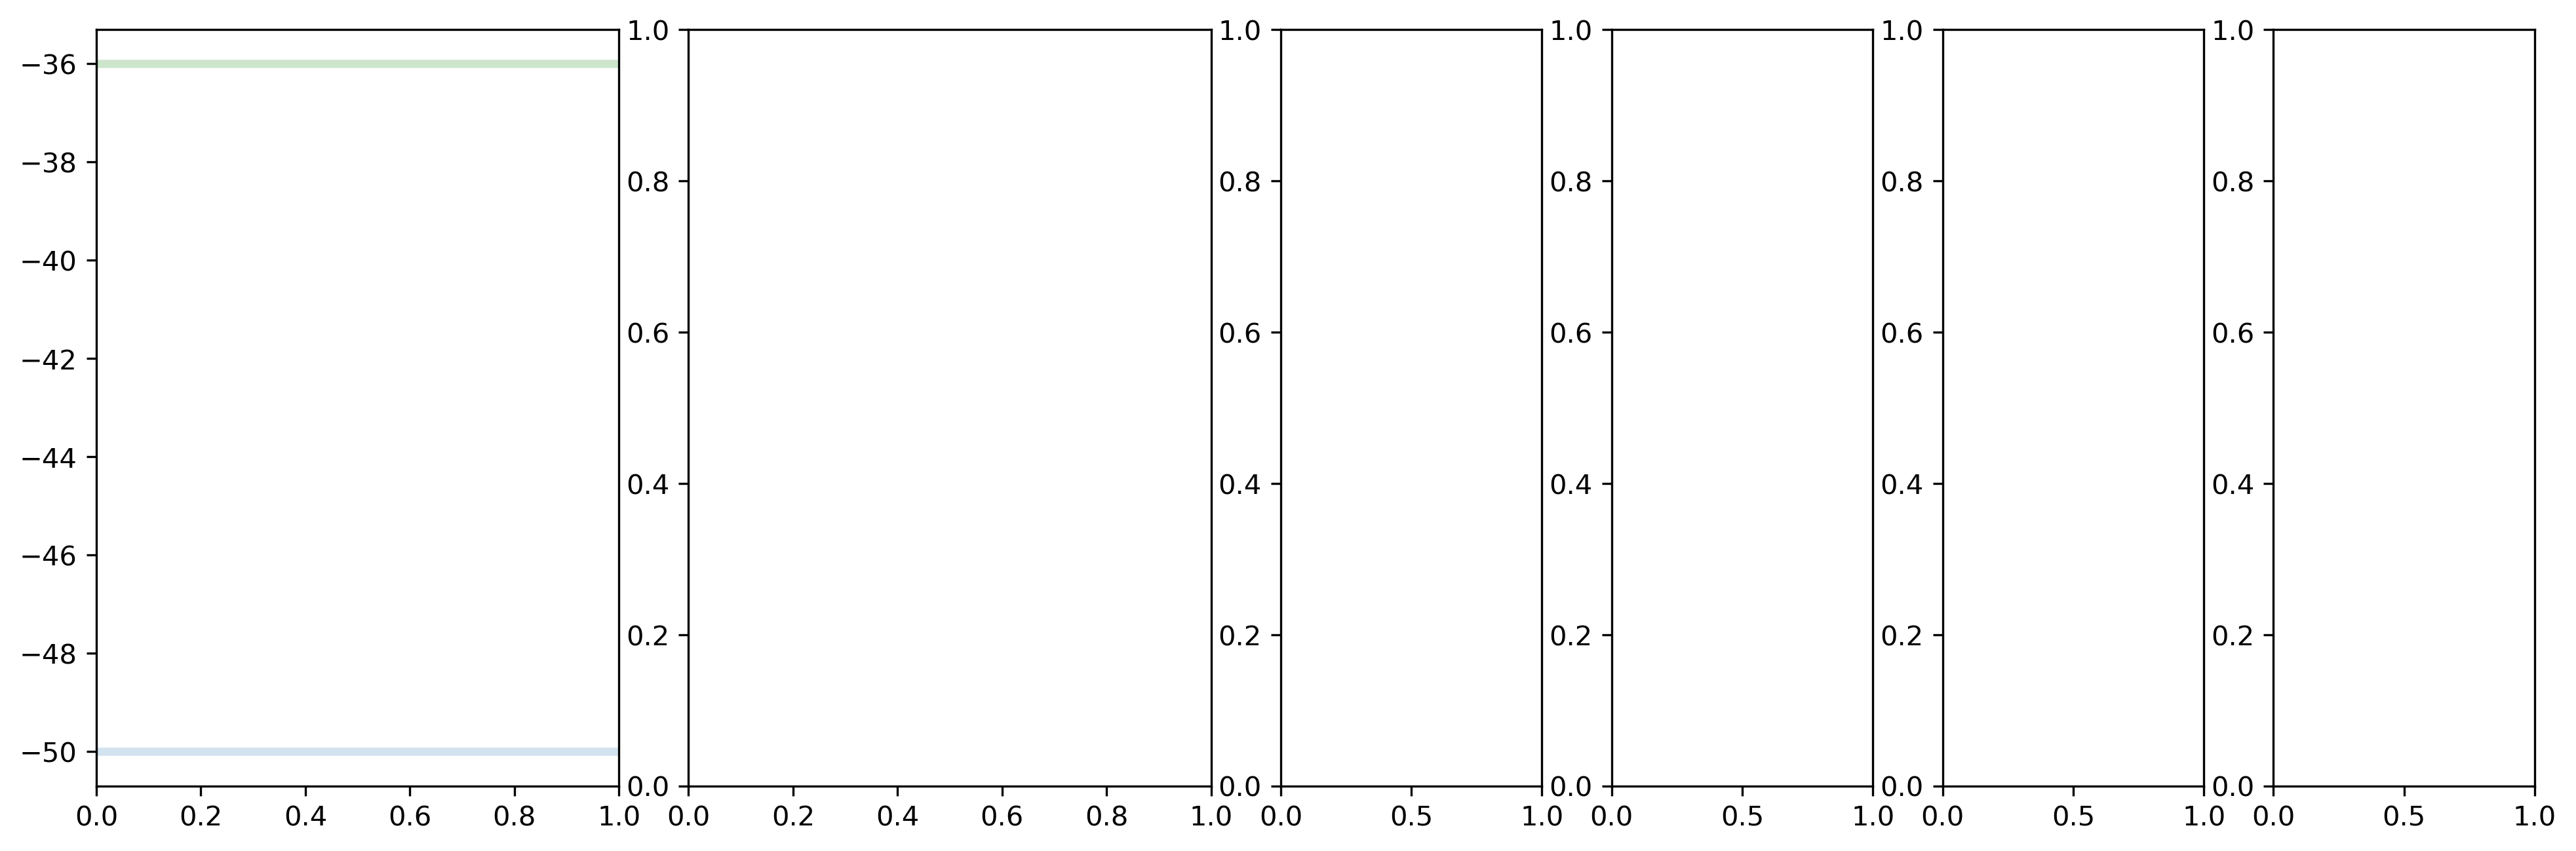

In [19]:
plot_bbp_comparison(
    r2_50=r2_50,
    mae_50=mae_50,
    bias_50=bias_50,
    depth="50",  # or "50"
    save_path="../results/Comparisons"
)